# Evaluation Metrics for ASR

## Catgories of Errors

When assessing speech recognition systems, we compare the system’s predictions to the target text transcriptions, annotating any errors that are present. We categorise these errors into one of three categories:

1. Substitutions (S): where we transcribe the wrong word in our prediction (“sit” instead of “sat”)
2. Insertions (I): where we add an extra word in our prediction
3. Deletions (D): where we remove a word in our prediction

These error categories are the same for all speech recognition metrics. What differs is the level at which we compute these errors: we can either compute them on the word level or on the character level

## Speech Recognition Metric: Word Error Rate

The word error rate (WER) metric is the ‘de facto’ metric for speech recognition. It calculates substitutions, insertions and deletions on the word level. This means errors are annotated on a word-by-word basis.

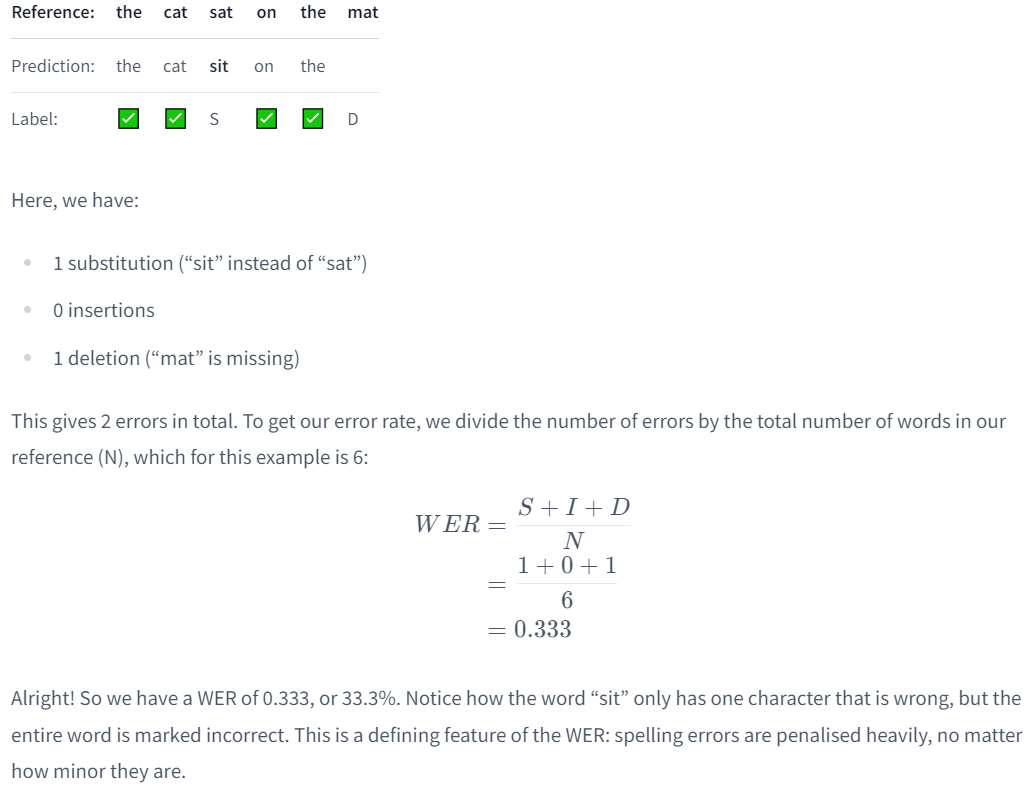

The WER is defined such that lower is better: a lower WER means there are fewer errors in our prediction, so a perfect speech recognition system would have a WER of zero (no errors).

Upper limit of WER:

Since the WER is the ratio of errors to number of words (N), there is no upper limit on the WER! Let’s take an example were we predict 10 words and the target only has 2 words. If all of our predictions were wrong (10 errors), we’d have a WER of 10 / 2 = 5, or 500%

In [1]:
from evaluate import load

"""   
Reference: Ground truth
"""

wer_metric = load("wer")

reference = "the cat sat on the mat"
prediction = "the cat sit on the"

wer = wer_metric.compute(references=[reference], predictions=[prediction])

print(wer)

0.3333333333333333


## WER vs CER

In general, the WER is used far more than the CER for assessing speech systems. This is because the WER requires systems to have greater understanding of the context of the predictions. In our example, “sit” is in the wrong tense. A system that understands the relationship between the verb and tense of the sentence would have predicted the correct verb tense of “sat”. We want to encourage this level of understanding from our speech systems. So although the WER is less forgiving than the CER, it’s also more conducive to the kinds of intelligible systems we want to develop. Therefore, we typically use the WER and would encourage you to as well! However, there are circumstances where it is not possible to use the WER. Certain languages, such as Mandarin and Japanese, have no notion of ‘words’, and so the WER is meaningless. Here, we revert to using the CER.

In our example, we only used one sentence when computing the WER. We would typically use an entire test set consisting of several thousand sentences when evaluating a real system. When evaluating over multiple sentences, we aggregate S, I, D and N across all sentences, and then compute the WER according to the formula defined above. This gives a better estimate of the WER for unseen data.

## Normalisation

```Orthographic```
If we train an ASR model on data with punctuation and casing, it will learn to predict casing and punctuation in its transcriptions. This is great when we want to use our model for actual speech recognition applications, such as transcribing meetings or dictation, since the predicted transcriptions will be fully formatted with casing and punctuation, a style referred to as orthographic.

```Normalising```
Normalising: normalising the dataset to remove any casing and punctuation

Normalising the dataset makes the speech recognition task easier: the model no longer needs to distinguish between upper and lower case characters, or have to predict punctuation from the audio data alone (e.g. what sound does a semi-colon make?). Because of this, the word error rates are naturally lower (meaning the results are better). However, the lack of casing and punctuation makes the predicted text from the model significantly harder to read.


### Whisper

The Whisper transcription is orthographic and thus ready to go - it’s formatted as we’d expect for a meeting transcription or dictation script with both punctuation and casing.

Meeting in the middle:
We can train our systems on orthographic transcriptions, and then normalise the predictions and targets before computing the WER. This way, we train our systems to predict fully formatted text, but also benefit from the WER improvements we get by normalising the transcriptions.
- benefit from the WER boost obtained by normalising the reference and prediction prior to computing the WER

The Whisper model was released with a normaliser that effectively handles the normalisation of casing, punctuation and number formatting among others

```Recommendation```: recommend training on orthographic text and evaluating on normalised text to get the best of both worlds

In [2]:
from transformers.models.whisper.english_normalizer import BasicTextNormalizer

normalizer = BasicTextNormalizer()

prediction = " He tells us that at this festive season of the year, with Christmas and roast beef looming before us, similarly is drawn from eating and its results occur most readily to the mind."
normalized_prediction = normalizer(prediction)

normalized_prediction

' he tells us that at this festive season of the year with christmas and roast beef looming before us similarly is drawn from eating and its results occur most readily to the mind '

In [3]:
reference = "HE TELLS US THAT AT THIS FESTIVE SEASON OF THE YEAR WITH CHRISTMAS AND ROAST BEEF LOOMING BEFORE US SIMILES DRAWN FROM EATING AND ITS RESULTS OCCUR MOST READILY TO THE MIND"
normalized_referece = normalizer(reference)

wer = wer_metric.compute(
    references=[normalized_referece], predictions=[normalized_prediction]
)
wer

0.0625

## Putting it all Together

Evaluate the pre-trained Whisper model on the Common Voice 13 Dhivehi test set
- Since Whisper does a good job transcribing data in high-resource languages, we want to test it on low-resource multilingual transcription
- Common Voice 13 is a crowd-sourced dataset where speakers record text from Wikipedia in various languages

The WER we get is the baseline for our fine-tuning task later

### Step 1: Load the pre-trained whisper model

```
"""
Precision refers to the number of bits used to represent floating-point numbers in computations

16-bit precision: This uses 16 bits to represent each floating-point number. It has less precision and a smaller range than float32, but it's faster and uses less memory
"""

from transformers import pipeline
import torch

if torch.cuda.is_available():
    device = "cuda:0"
    torch_dtype = torch.float16
else:
    device = "cpu"
    torch_dtype = torch.float32

pipe = pipeline(
    "automatic-speech-recognition",
    model="openai/whisper-small",
    torch_dtype=torch_dtype,
    device=device,
)
```

### Step 2: Load the Dhivehi test split of Common Voice 13

The Common Voice 13 dataset is gated, meaning we had to agree to the dataset terms of use before gaining access to the dataset. 

We can now link our Hugging Face account to our notebook, so that we have access to the dataset from the machine we’re currently using.

```
from huggingface_hub import notebook_login

notebook_login()
```

Simply enter your Hub authentication token when prompted

```
from datasets import load_dataset

common_voice_test = load_dataset(
    "mozilla-foundation/common_voice_13_0", "dv", split="test"
)
```

### Step 3: Predict the test split

```
from tqdm import tqdm # Create progress bars
# Stream data from a specific col in a dataset (memory-efficient)
from transformers.pipelines.pt_utils import KeyDataset

# Initialise text transcriptions of audio samples/model outputs/predictions
all_predictions = []

# run streamed inference
for prediction in tqdm(
    pipe(
        # Create a KeyDataset. Stream only the audio col to the model one batch at a time
        KeyDataset(common_voice_test, "audio"),
        max_new_tokens=128,
        generate_kwargs={"task": "transcribe"},
        batch_size=32,
    ),
    total=len(common_voice_test),
):

    all_predictions.append(prediction["text"])
```

The pipeline processes the data in batches of 32 samples at a time 
However, when you iterate over the results using the for loop, each iteration processes one prediction at a time, which corresponds to one audio sample from that batch

The pipeline processes the batch and returns predictions one by one as you loop through them.

The for loop handles the predictions one by one, even though the pipeline processes the data in batches for efficiency.

### Step 4: Evaluate the test split

Compute the WER (Orthographic WER)

```
from evaluate import load

wer_metric = load("wer")

wer_ortho = 100 * wer_metric.compute(
    references=common_voice_test["sentence"], predictions=all_predictions
)
wer_ortho
```

Compute the WER (Normalised WER) - WER with normalisation post-processing

```
from transformers.models.whisper.english_normalizer import BasicTextNormalizer

normalizer = BasicTextNormalizer()

# compute normalised WER

# Normalised samples
all_predictions_norm = [normalizer(pred) for pred in all_predictions]
all_references_norm = [normalizer(label) for label in common_voice_test["sentence"]]

# filtering step to only evaluate the samples that correspond to non-zero references
all_predictions_norm = [
    all_predictions_norm[i]
    for i in range(len(all_predictions_norm))
    if len(all_references_norm[i]) > 0
]
all_references_norm = [
    all_references_norm[i]
    for i in range(len(all_references_norm))
    if len(all_references_norm[i]) > 0
]

wer = 100 * wer_metric.compute(
    references=all_references_norm, predictions=all_predictions_norm
)

wer
```